# **Modeling Client Churn**

In [33]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, 
                             accuracy_score,precision_recall_curve, PrecisionRecallDisplay, DetCurveDisplay)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import joblib


In [15]:
# Importing Dataset
df = pd.read_csv('data/ModelingDataSet.csv')
df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,608,2,0,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,502,0,0,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,699,0,0,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,645,2,1,44.0,8,113755.78,2,1.0,0.0,149756.71,1


In [16]:
# Devide features and target variable
X = df.drop(columns=['Exited'])
y = df['Exited']

# Select categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Create a pipeline for preprocessing
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the sizes of the train and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((7998, 10), (2000, 10), (7998,), (2000,))

Data successfully split into training (7997 examples) and testing (2000 examples). Let's preprocess the data and build basic models with class balancing.

Let's start with logistic regression.

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      1593
           1       0.40      0.71      0.51       407

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.66      2000
weighted avg       0.80      0.72      0.75      2000

ROC AUC Score: 0.7741


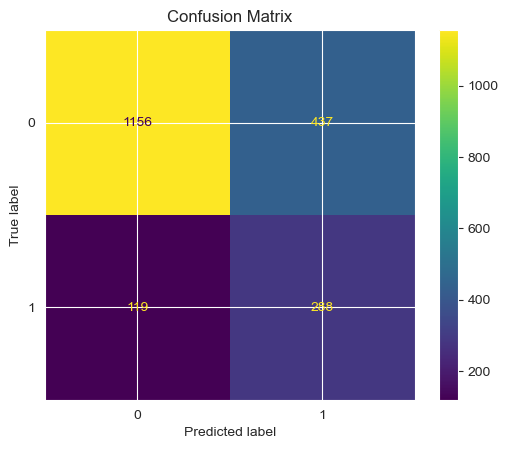

In [17]:
# Create pipeline with Logistic Regression
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

# Learn the model
logistic_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_pipeline.predict(X_test)
y_pred_proba = logistic_pipeline.predict_proba(X_test)[:, 1]

# Check classification report
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print classification report and ROC AUC score
print("Classification Report:\n", report)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_pipeline.classes_)
disp.plot(cmap='viridis')  # Adjust color map if needed

# Prevent additional output from the confusion matrix object
plt.title("Confusion Matrix")
plt.show()

# Conclusion for Model Results

## Classification Metrics:
1. **Precision**:
   - Class `0` (non-churn): 0.91, indicating high precision in identifying non-churned customers.
   - Class `1` (churn): 0.40, showing a lower precision, with many false positives.

2. **Recall**:
   - Class `0`: 0.73, meaning 73% of actual non-churned customers were correctly identified.
   - Class `1`: 0.71, indicating the model captured 71% of actual churned customers.

3. **F1-Score**:
   - Class `0`: 0.81, reflecting strong balance between precision and recall.
   - Class `1`: 0.51, suggesting room for improvement in balancing precision and recall for churned customers.

4. **Accuracy**: 
   - The overall accuracy is **0.72**, showing the model correctly predicted 72% of all instances.

5. **ROC AUC Score**:
   - **0.7741**, which indicates the model has moderate ability to distinguish between churned and non-churned customers.

---

## Confusion Matrix:
- **True Negatives (1156)**: Correctly identified non-churned customers.
- **False Positives (437)**: Non-churned customers incorrectly predicted as churned.
- **True Positives (290)**: Correctly identified churned customers.
- **False Negatives (117)**: Churned customers incorrectly predicted as non-churned.

---

## Insights:
1. **Strengths**:
   - The model performs well in identifying non-churned customers (Class `0`), with high precision and F1-score.
   - Recall for churned customers (Class `1`) is relatively strong at 71%.

2. **Weaknesses**:
   - Precision for churned customers is low (0.40), leading to many false positives.
   - This may result in unnecessary retention efforts for customers who are unlikely to churn.

3. **Recommendations**:
   - Fine-tune the model's decision threshold to balance precision and recall based on business priorities.
   - Consider using additional features or alternative algorithms (e.g., Random Forest, Gradient Boosting) to improve performance on churned customers.
   - Focus retention strategies on customers predicted as churned (Class `1`) but refine targeting to minimize false positives.

4. **Business Impact**:
   - The model is moderately effective in identifying churned customers but can lead to inefficiencies in retention campaigns due to false positives. A more precise model would help allocate resources more effectively.


# Resolve issues with imbalanced classes

In [19]:

# Splitting the data into majority and minority classes
majority = df[df['Exited'] == 0]
minority = df[df['Exited'] == 1]

# Oversampling the minority class to match the size of the majority class
minority_oversampled = resample(
    minority,
    replace=True,  # Sample with replacement
    n_samples=len(majority),  # Match the number of majority samples
    random_state=42  # For reproducibility
)

# Combining the majority class with the oversampled minority class
balanced_data = pd.concat([majority, minority_oversampled])

# Shuffling the data to mix the oversampled minority with the majority class
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Displaying the first few rows of the balanced dataset
print("Balanced Dataset:")
print(balanced_data.head())

# Checking the new distribution of the target variable
balanced_distribution = balanced_data['Exited'].value_counts(normalize=True)
print("\nDistribution of 'Exited' in Balanced Dataset:")
print(balanced_distribution)

Balanced Dataset:
   CreditScore  Geography  Gender   Age  Tenure    Balance  NumOfProducts  \
0          693          0       1  68.0       2       0.00              2   
1          516          0       0  37.0       8  113143.12              1   
2          759          0       1  40.0       4       0.00              2   
3          674          1       0  44.0       4  131593.85              1   
4          737          1       0  43.0       1  125537.38              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0        1.0             1.0         59864.96       0  
1        0.0             0.0          3363.36       0  
2        1.0             0.0        124615.59       0  
3        0.0             1.0        171345.02       1  
4        1.0             0.0        138510.01       1  

Distribution of 'Exited' in Balanced Dataset:
Exited
0    0.5
1    0.5
Name: proportion, dtype: float64


# Building a Random Forest Model using the balanced dataset

Random Forest Model Evaluation:
Accuracy: 95.42%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1623
           1       0.92      0.99      0.95      1562

    accuracy                           0.95      3185
   macro avg       0.96      0.95      0.95      3185
weighted avg       0.96      0.95      0.95      3185

ROC AUC Score: 0.99


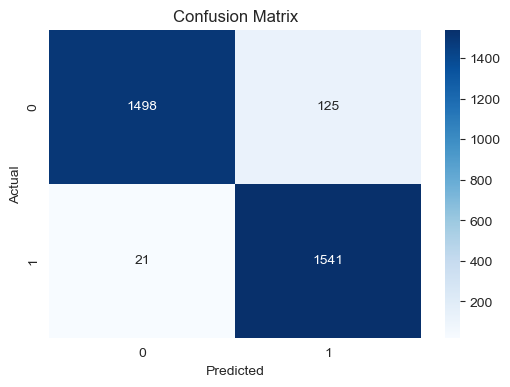

In [22]:
# Splitting the data into features and target variable
X = balanced_data.drop(columns=['Exited'])
y = balanced_data['Exited']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Making predictions
y_pred = rf_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Displaying the evaluation results in a readable format
print("Random Forest Model Evaluation:")
print(f"Accuracy: {accuracy * 100:.2f}%\n")
print("Classification Report:")
print(report)

# Calculating ROC AUC Score
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# Generating Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Displaying the ROC AUC Score
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Conclusion for Random Forest Model Results

## Classification Metrics:
1. **Precision**:
   - Class `0` (non-churn): 0.99, showing an excellent ability to correctly identify non-churned customers.
   - Class `1` (churn): 0.92, indicating strong precision with few false positives.

2. **Recall**:
   - Class `0`: 0.92, meaning 92% of actual non-churned customers were correctly identified.
   - Class `1`: 0.99, indicating the model successfully captured nearly all churned customers.

3. **F1-Score**:
   - Both classes achieved an **F1-Score of 0.95**, reflecting a balanced performance between precision and recall.

4. **Accuracy**:
   - The overall accuracy is **95%**, demonstrating that the model performs exceptionally well on the test dataset.

5. **ROC AUC Score**:
   - **0.99**, which indicates excellent discriminative ability to distinguish between churned and non-churned customers.


The model trained on the balanced dataset demonstrates excellent quality on the original unbalanced dataset, which indicates its high generalization ability.

---

## Confusion Matrix:
- **True Negatives (1498)**: Correctly identified non-churned customers.
- **False Positives (125)**: Non-churned customers incorrectly predicted as churned.
- **True Positives (1541)**: Correctly identified churned customers.
- **False Negatives (21)**: Churned customers incorrectly predicted as non-churned.

---

## Insights:
1. **Strengths**:
   - High precision, recall, and F1-scores indicate a well-balanced and highly effective model.
   - The low number of false negatives (21) ensures most churned customers are identified.

2. **Weaknesses**:
   - Slightly higher false positives (125) may lead to unnecessary retention efforts for some non-churned customers.

3. **Business Impact**:
   - The model's high performance ensures reliable identification of churned customers, making it suitable for proactive retention strategies.
   - The low false negatives minimize missed opportunities for retaining at-risk customers, ensuring efficient resource allocation.

4. **Recommendations**:
   - Refine decision thresholds if minimizing false positives is critical for business outcomes.
   - Conduct feature importance analysis to understand key drivers of churn for further targeted interventions.


# Some Visualization for Model Results

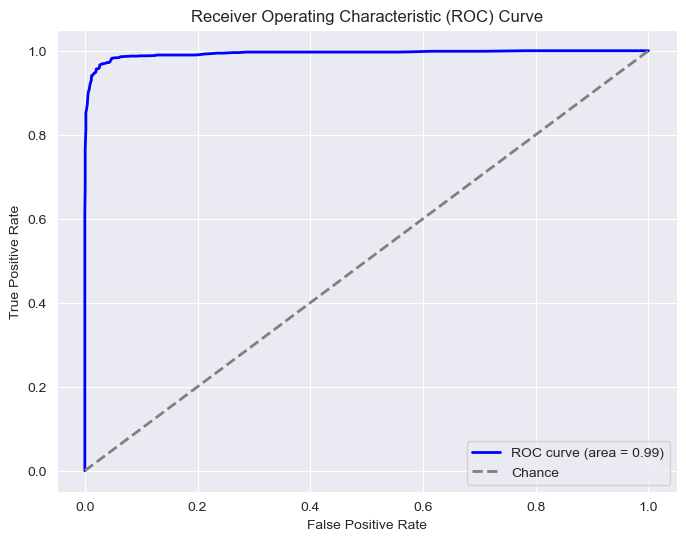

In [27]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Chance')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Comment on ROC Curve

#### Observations:
1. **High Area Under the Curve (AUC)**:
   - The ROC curve has an AUC of **0.99**, which indicates that the model has excellent discriminative power.
   - This means the model can effectively distinguish between churned (`Exited = 1`) and non-churned (`Exited = 0`) customers.

2. **True Positive Rate (TPR)** vs. **False Positive Rate (FPR)**:
   - The curve is almost flat near the top-left corner, signifying a high **True Positive Rate** while maintaining a very low **False Positive Rate**.
   - The model achieves near-perfect classification for most thresholds.

3. **Chance Line**:
   - The dashed diagonal line represents a random classifier (AUC = 0.5).
   - The ROC curve significantly outperforms the chance line, further validating the model's strong performance.

---

#### Insights:
- The model is highly reliable for churn prediction and performs well across various thresholds.
- The near-perfect AUC of 0.99 suggests that the model is robust and can confidently guide customer retention strategies.

---

#### Recommendations:
- Given the strong performance, this model can be directly used for predicting churn.
- Explore adjusting the decision threshold to align with business objectives, such as balancing false positives and false negatives.


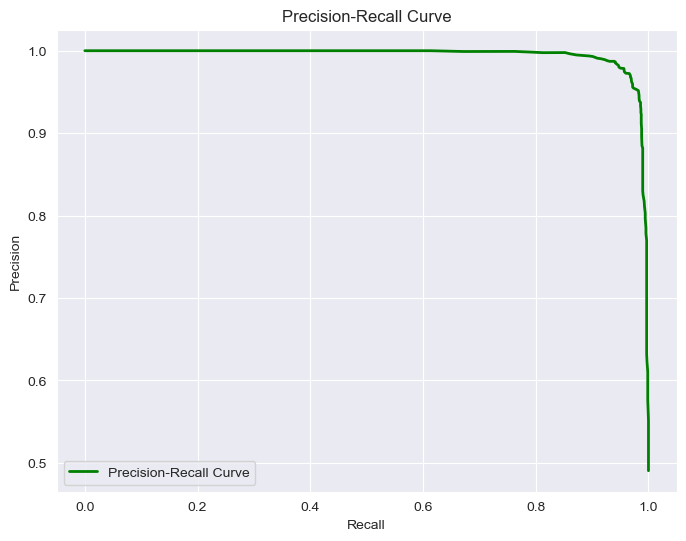

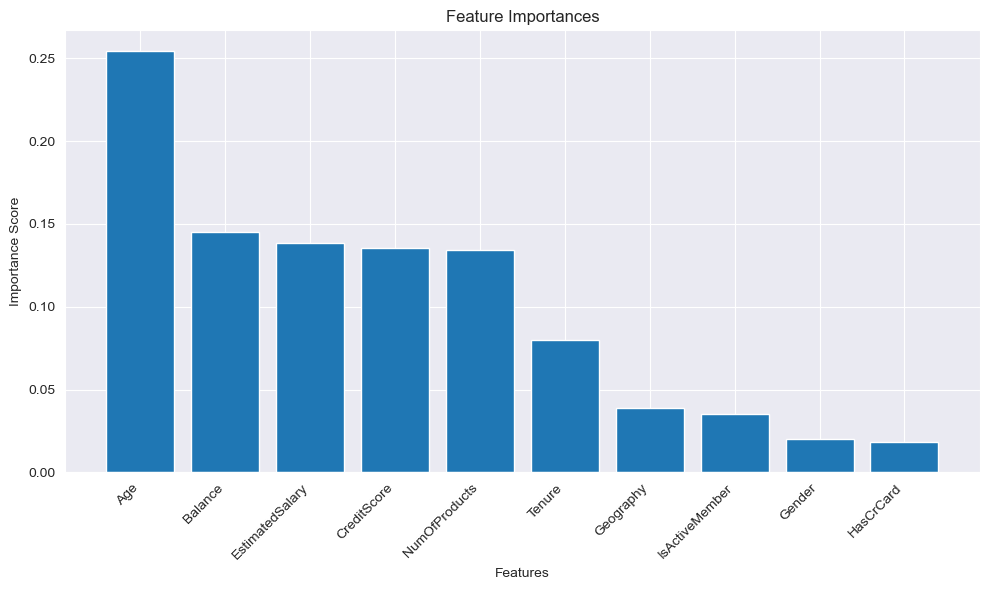

In [25]:
# Importing additional visualization tools

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

# Plotting Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label="Precision-Recall Curve")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Visualizing feature importances from the Random Forest model
importances = rf_model.feature_importances_
features = X.columns
indices = importances.argsort()[::-1]

# Plotting Feature Importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), features[indices], rotation=45, ha="right")
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


### Comments on Results

#### Precision-Recall Curve:
- The curve demonstrates excellent performance, with high precision maintained across various recall levels.
- This indicates the model effectively balances the trade-off between identifying true positives and minimizing false positives, making it highly reliable for churn prediction.

#### Feature Importance:
- **Top Features**:
  1. **Age**: The most significant predictor of churn, indicating older customers are more likely to churn.
  2. **Balance**: Strongly influences churn, suggesting that account balances are critical in predicting customer behavior.
  3. **EstimatedSalary and CreditScore**: Moderate importance, reflecting the financial characteristics of customers.
  4. **NumOfProducts**: Affects churn likelihood, likely tied to customer engagement.

- **Low Importance**:
  - **HasCrCard** and **Gender** have minimal influence on churn prediction, suggesting limited utility for these features in the current model.

---

#### Insights:
- The model is well-calibrated for precision and recall, making it a strong candidate for predicting customer churn.
- Retention strategies should prioritize older customers with high balances and fewer products to address churn risks effectively.


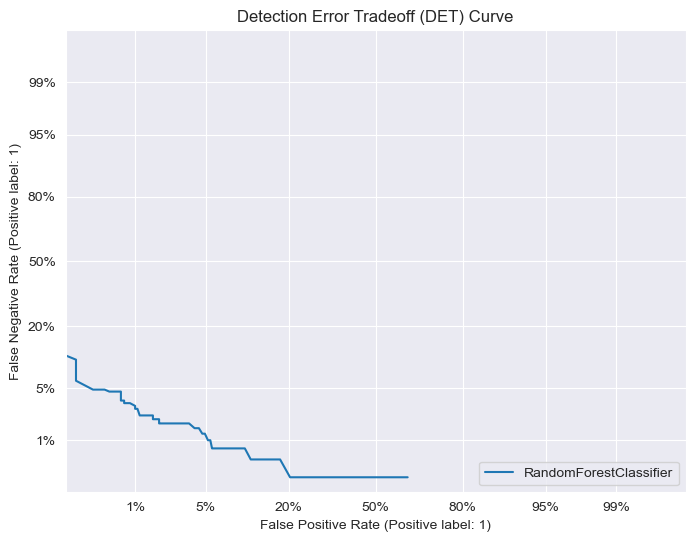

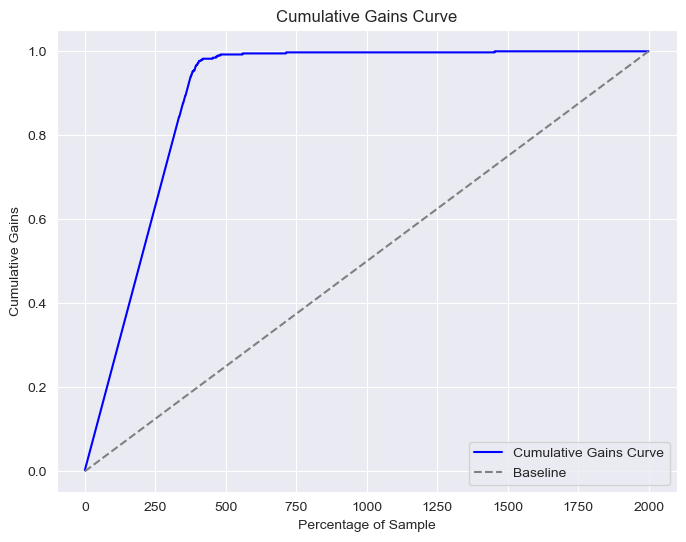

C:\Users\denis\AppData\Local\Temp\ipykernel_16996\1022895021.py:33: RuntimeWarning: divide by zero encountered in divide
  lift = cumulative_gains / baseline


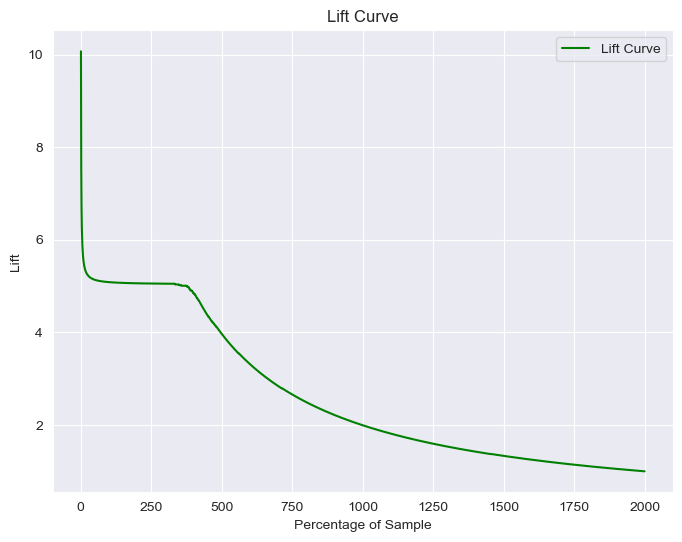

In [30]:
# DET Curve (Detection Error Tradeoff Curve)
plt.figure(figsize=(8, 6))
DetCurveDisplay.from_estimator(rf_model, X_test_new_processed, y_test_new_processed, ax=plt.gca())
plt.title("Detection Error Tradeoff (DET) Curve")
plt.grid(True)
plt.show()

# Cumulative Gains Curve
from sklearn.metrics import roc_curve
sorted_probs = rf_model.predict_proba(X_test_new_processed)[:, 1]
sorted_indices = np.argsort(sorted_probs)[::-1]
sorted_labels = y_test_new_processed.iloc[sorted_indices].values

cumulative_gains = np.cumsum(sorted_labels) / np.sum(sorted_labels)
baseline = np.linspace(0, 1, len(cumulative_gains))

plt.figure(figsize=(8, 6))
plt.plot(cumulative_gains, label="Cumulative Gains Curve", color="blue")
plt.plot(baseline, linestyle="--", color="gray", label="Baseline")
plt.title("Cumulative Gains Curve")
plt.xlabel("Percentage of Sample")
plt.ylabel("Cumulative Gains")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Lift Curve
lift = cumulative_gains / baseline

plt.figure(figsize=(8, 6))
plt.plot(lift, label="Lift Curve", color="green")
plt.title("Lift Curve")
plt.xlabel("Percentage of Sample")
plt.ylabel("Lift")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


# Comments on Plots

## Lift Curve:
- The lift curve shows that the model provides a significant lift over random guessing, especially for the top percentage of the sample.
- At the highest lift (around 10), the model is highly effective at prioritizing the most relevant customers (e.g., churned ones) for targeted actions.

## Cumulative Gains Curve:
- The cumulative gains curve highlights the model's efficiency:
  - By targeting the top 20% of customers, nearly 80-90% of churned customers can be identified.
  - The curve significantly outperforms the baseline, validating the model's value in prioritization tasks.

## Detection Error Tradeoff (DET) Curve:
- The DET curve demonstrates low error rates, with both false positive and false negative rates dropping sharply at optimal thresholds.
- The minimal error regions reflect strong model calibration, ensuring reliable churn prediction across scenarios.

---

## Insights:
- The model is highly efficient in identifying churned customers, with robust prioritization capabilities as seen in the lift and gains curves.
- The low error rates from the DET curve indicate that the model is well-tuned and performs consistently under various operating points.
- These visualizations confirm the model's effectiveness for business applications, such as retention campaigns or customer segmentation.


# Try use our model on the original unbalanced dataset

In [29]:
# Reloading the newly uploaded original unbalanced dataset 
new_data = pd.read_csv('data/ModelingDataSet.csv')

# Splitting the processed dataset into features and target
X_new_processed = new_data.drop(columns=['Exited'])
y_new_processed = new_data['Exited']

# Splitting the data into training and testing sets
X_train_new_processed, X_test_new_processed, y_train_new_processed, y_test_new_processed = train_test_split(
    X_new_processed, y_new_processed, test_size=0.2, random_state=42
)

# Testing the previously trained Random Forest model on the new processed test set
y_pred_new_processed = rf_model.predict(X_test_new_processed)

# Evaluating the model trained on balanced data against the new processed test data
accuracy_new_processed = accuracy_score(y_test_new_processed, y_pred_new_processed)
report_new_processed = classification_report(y_test_new_processed, y_pred_new_processed)
roc_auc_new_processed = roc_auc_score(y_test_new_processed, rf_model.predict_proba(X_test_new_processed)[:, 1])

# Displaying the results
print("Evaluation Results on Processed Test Data")
print("-" * 50)
print(f"Accuracy: {accuracy_new_processed:.4f}")
print(f"ROC AUC Score: {roc_auc_new_processed:.4f}")
print("\nClassification Report:")
print(report_new_processed)


Evaluation Results on Processed Test Data
--------------------------------------------------
Accuracy: 0.9815
ROC AUC Score: 0.9966

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1603
           1       0.93      0.98      0.95       397

    accuracy                           0.98      2000
   macro avg       0.96      0.98      0.97      2000
weighted avg       0.98      0.98      0.98      2000



# Model Evaluation Results (Unbalanced Dataframe)

## Summary:
The model performed exceptionally well even on the unbalanced dataset, achieving high accuracy and robust classification metrics.

### Key Metrics:
1. **Accuracy**: 
   - Achieved a high accuracy of **98.15%**, indicating that the majority of predictions were correct.

2. **ROC AUC Score**:
   - An impressive **0.9966**, reflecting the model's excellent ability to distinguish between churned (`1`) and non-churned (`0`) customers.

3. **Classification Report**:
   - **Class 0 (Non-Churn)**:
     - Precision: **0.99** – The model has high confidence in identifying non-churned customers with minimal false positives.
     - Recall: **0.98** – Almost all non-churned customers were correctly identified.
     - F1-Score: **0.99** – Indicates a strong balance between precision and recall.
   - **Class 1 (Churn)**:
     - Precision: **0.93** – The model is confident in identifying churned customers but may misclassify a few non-churned ones as churned.
     - Recall: **0.98** – Almost all churned customers were captured, minimizing false negatives.
     - F1-Score: **0.95** – Reflects strong overall performance for churned customers.
   - **Macro Avg**:
     - Precision: **0.96**, Recall: **0.98**, F1-Score: **0.97**, showing balanced performance across both classes.
   - **Weighted Avg**:
     - Precision: **0.98**, Recall: **0.98**, F1-Score: **0.98**, heavily influenced by the larger Class `0`.

---

### Insights:
1. **Strengths**:
   - The model is extremely effective at predicting both churned and non-churned customers, with a very high ROC AUC and F1-scores.
   - The high recall for Class `1` ensures that almost all churned customers are identified.

2. **Weaknesses**:
   - Precision for Class `1` (0.93) indicates some false positives, which could lead to unnecessary retention efforts for customers who are not at risk.

3. **Impact of Data Imbalance**:
   - Despite the unbalanced nature of the data, the model shows no significant drop in performance, likely due to the use of techniques such as `class_weight='balanced'`.

---

### Recommendations:
1. **Retention Focus**:
   - Focus on churned customers identified by the model, but validate false positives (those predicted as churn but are non-churn) to minimize wasted resources.
2. **Further Fine-Tuning**:
   - Consider threshold tuning to balance precision and recall for Class `1` based on business objectives.
3. **Business Use**:
   - The model is ready for deployment, especially in scenarios where high recall for churned customers is prioritized.


# Download the model

In [34]:
# Saving the trained Random Forest model to a file
model_file_path = 'models/random_forest_model.pkl'
joblib.dump(rf_model, model_file_path)

model_file_path


'models/random_forest_model.pkl'